# Project One

### Authors: Daniel Canales | Daniel Do | Micah Baylor | Yixiao Yang 

# Objective: 
To reconstruct the demographic and humanitarian landscape of Cambodia during the Khmer Rouge regime by aggregating and analyzing fragmented data sets to uncover hidden patterns of the period.

## Methodology & Data Collection: 

Our analysis focused on three primary data pillars to bridge the "information gap" caused by the regime’s destruction of formal records:

### Geospatial Analysis of Mass Graves: 
Mapping burial sites to estimate the scale and geographic distribution of mortality.

Demographic Reconstruction: Analyzing population pyramids to visualize the drastic "hollow-out" of specific age cohorts.

Gender-Based Divergence: Comparing male and female survival rates to identify how the regime’s labor and purge policies affected genders differently.

In [3]:
!pip install wbdata

  Using cached wbdata-1.1.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached dateparser-1.3.0-py3-none-any.whl.metadata (30 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
Using cached wbdata-1.1.0-py3-none-any.whl (18 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached dateparser-1.3.0-py3-none-any.whl (318 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached tzlocal-5.3.1-py3-none-any.whl (18 kB)
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cach

## 1. [A] Population Statistics

In [28]:
import wbdata
import pandas as pd

INDICATORS = {
    "SP.POP.TOTL": "total",
    "SP.POP.0014.TO.ZS": "age_0_14_pct",
    "SP.POP.1564.TO.ZS": "age_15_64_pct",
    "SP.POP.65UP.TO.ZS": "age_65_up_pct",
    "SP.POP.TOTL.MA.ZS": "male_pct",
    "SP.POP.TOTL.FE.ZS": "female_pct",
}

def split_age_share(age_range):
    fine_low, fine_high = age_range
    coarse_bins = [(0,14), (15,64), (65,100)]
    weights = {}

    for c_low, c_high in coarse_bins:
        overlap_low = max(fine_low, c_low)
        overlap_high = min(fine_high, c_high)
        if overlap_low <= overlap_high:
            overlap = overlap_high - overlap_low + 1
            total = c_high - c_low + 1
            weights[(c_low, c_high)] = overlap / total

    return weights


def population(year, sex, age_range, place):

    df = wbdata.get_dataframe(INDICATORS, country=place)
    df.index = pd.to_datetime(df.index).year
    df = df.sort_index()

    if df.empty or year not in df.index:
        raise ValueError(f"No data for place={place}, year={year}")

    row = df.loc[year]
    total = float(row["total"])

    # sex share
    s = str(sex).lower()
    if s in ["people", "all", "total"]:
        sex_share = 1.0
    elif s in ["male", "males", "man", "men"]:
        sex_share = float(row["male_pct"]) / 100.0
    elif s in ["female", "females", "woman", "women"]:
        sex_share = float(row["female_pct"]) / 100.0
    else:
        raise ValueError("sex must be people/male/female")

    # age share (supports arbitrary ranges)
    if age_range == (0,100):
        age_share = 1.0
    else:
        weights = split_age_share(age_range)
        age_share = 0
        for (c_low, c_high), w in weights.items():
            if (c_low, c_high) == (0,14):
                age_share += w * float(row["age_0_14_pct"]) / 100
            elif (c_low, c_high) == (15,64):
                age_share += w * float(row["age_15_64_pct"]) / 100
            elif (c_low, c_high) == (65,100):
                age_share += w * float(row["age_65_up_pct"]) / 100

    return total * sex_share * age_share


## 2. [A] Unit Test

In [29]:
# total world population
t_wld = population(2000, "people", (0,100), "WLD")
assert t_wld > 5e9, "World population in 2000 should be > 5 billion"

# male and female share of pop
m_wld = population(2000, "male", (0,100), "WLD")
f_wld = population(2000, "female", (0,100), "WLD")
assert abs((m_wld + f_wld) - t_wld) / t_wld < 0.03, "Male+Female should be close to total"

# male share of pop
assert 0.45 < m_wld / t_wld < 0.55, "Male share should be around 50%"

# custom age bins
bins = [(0,10), (11,20), (21,30), (31,40), (41,50), (51,100)]
sum_bins = sum(population(2000, "people", b, "WLD") for b in bins)
assert abs(sum_bins - t_wld) / t_wld < 0.10, "Custom age bins should sum close to total"

## 3. [A] Population Dataframe

In [30]:
def population_dataframe(places, years):
    """
    Return a DataFrame indexed by (place, year).
    Columns are population counts for age-sex groups (3 age bins x 2 sexes).
    """
    rows = []
    for p in places:
        for y in years:
            rows.append({
                "place": p,
                "year": y,
                "Male_0_10": population(y, "male", (0,10), p),
                "Male_11_20": population(y, "male", (11,20), p),
                "Male_21_30": population(y, "male", (21,30), p),
                "Male_31_40": population(y, "male", (31,40), p),
                "Male_41_50": population(y, "male", (41,50), p),
                "Male_51_100": population(y, "male", (51,100), p),
                "Female_0_10": population(y, "female", (0,10), p),
                "Female_11_20": population(y, "female", (11,20), p),
                "Female_21_30": population(y, "female", (21,30), p),
                "Female_31_40": population(y, "female", (31,40), p),
                "Female_41_50": population(y, "female", (41,50), p),
                "Female_51_100": population(y, "female", (51,100), p),
            })
    return pd.DataFrame(rows).set_index(["place", "year"]).sort_index()

In [31]:
df = population_dataframe(places=["KHM"],years=range(1970, 1990))
df.head()

Male_0_10     Male_11_20     Male_21_30     Male_31_40  \
place year                                                              
KHM   1970  1.080796e+06  602927.844989  349851.722880  349851.722880   
      1971  1.088014e+06  601036.419240  342324.963544  342324.963544   
      1972  1.095284e+06  603476.883023  341986.439284  341986.439284   
      1973  1.100003e+06  606218.065352  343694.987128  343694.987128   
      1974  1.096548e+06  606010.895013  345443.455588  345443.455588   

               Male_41_50    Male_51_100   Female_0_10   Female_11_20  \
place year                                                              
KHM   1970  349851.722880  588510.755403  1.079365e+06  602129.577591   
      1971  342324.963544  579469.727066  1.097882e+06  606487.794093   
      1972  341986.439284  580476.995632  1.116324e+06  615069.521603   
      1973  343694.987128  584347.529462  1.131933e+06  623815.003396   
      1974  345443.455588  588259.478657  1.139044e+06  629496.544987   

             Female_21_30   Female_31_40   Female_41_50  Female_51_100  
place year                                                              
KHM   1970  349388.524460  349388.524460  349388.524460  587731.576014  
      1971  345429.836456  345429.836456  345429.836456  584725.492934  
      1972  348555.912451  348555.912451  348555.912451  591627.812181  
      1973  353671.561137  353671.561137  353671.561137  601309.622577  
      1974  358830.944412  358830.944412  358830.944412  611057.181343

##  4. [B] Population Pyramids

In [32]:
import matplotlib.pyplot as plt

def plot_population_pyramid_matplotlib(df, place, year):
    year_df = df.loc[(place, year)]

    age_groups = ["0–10", "11–20", "21–30", "31–40", "41–50", "51+"]

    male_counts = [
        -year_df["Male_0_10"],
        -year_df["Male_11_20"],
        -year_df["Male_21_30"],
        -year_df["Male_31_40"],
        -year_df["Male_41_50"],
        -year_df["Male_51_100"],
    ]

    female_counts = [
        year_df["Female_0_10"],
        year_df["Female_11_20"],
        year_df["Female_21_30"],
        year_df["Female_31_40"],
        year_df["Female_41_50"],
        year_df["Female_51_100"],
    ]

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.barh(age_groups, male_counts, color="blue", label="Males")
    ax.barh(age_groups, female_counts, color="pink", label="Females")

    ax.set_xlabel("Population")
    ax.set_ylabel("Age Group")
    ax.set_title(f"Population Pyramid for {place} ({year})")
    ax.legend()

    # Make x-axis symmetric
    max_val = max(max(female_counts), max(-x for x in male_counts))
    ax.set_xlim(-max_val * 1.1, max_val * 1.1)

    ax.axvline(0, color="black", linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

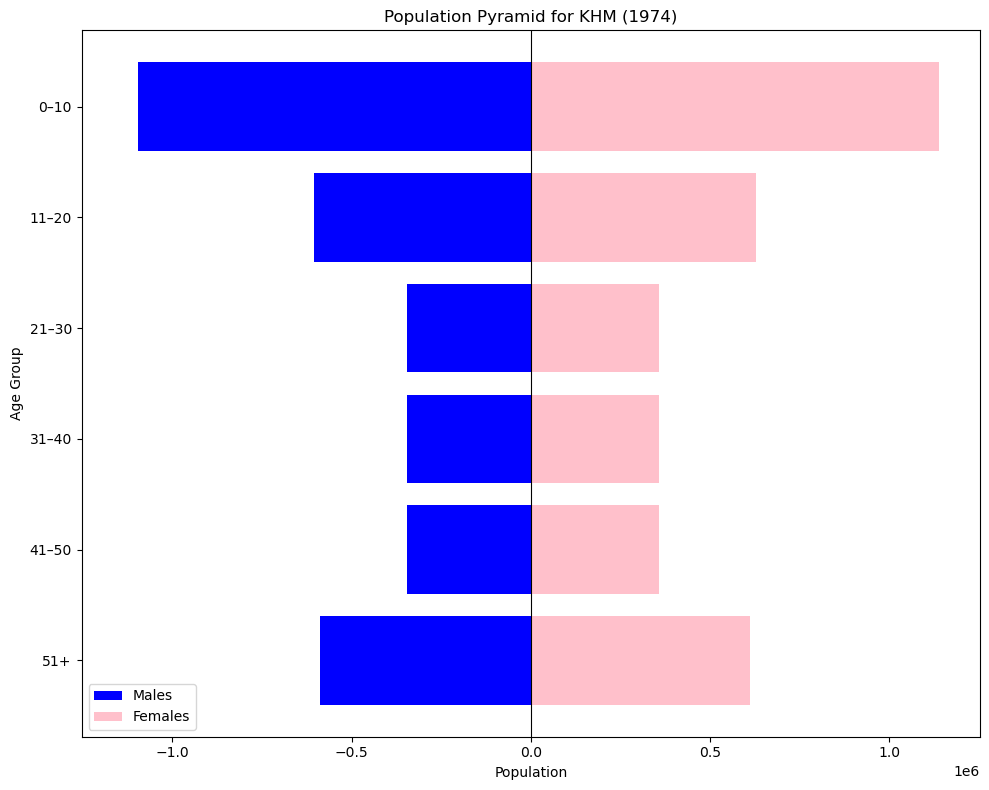

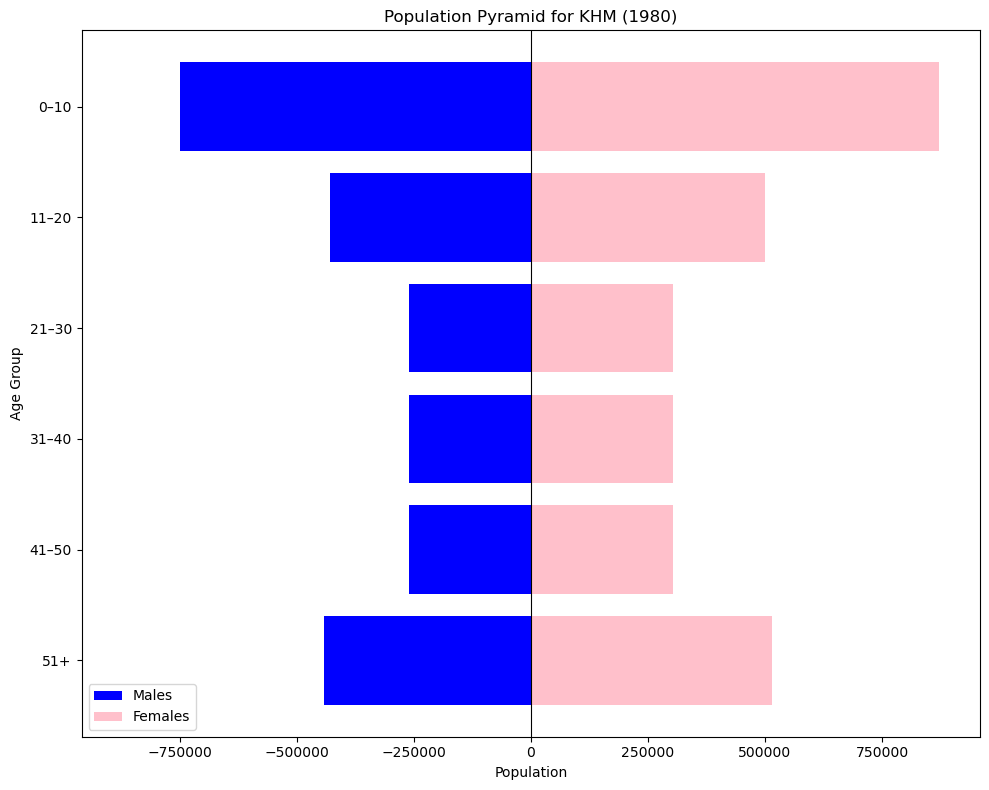

In [33]:
plot_population_pyramid_matplotlib(df, "KHM", 1974)
plot_population_pyramid_matplotlib(df, "KHM", 1980)

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")

In [35]:
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


## 6. [C] Population Maps

In [37]:
killings = pd.DataFrame({"ISO_A3": ["KHM", "TZA", "UGA"],"killings": [1200, 3400, 900]})
geo = world.merge(killings, on ="ISO_A3", how= "left")

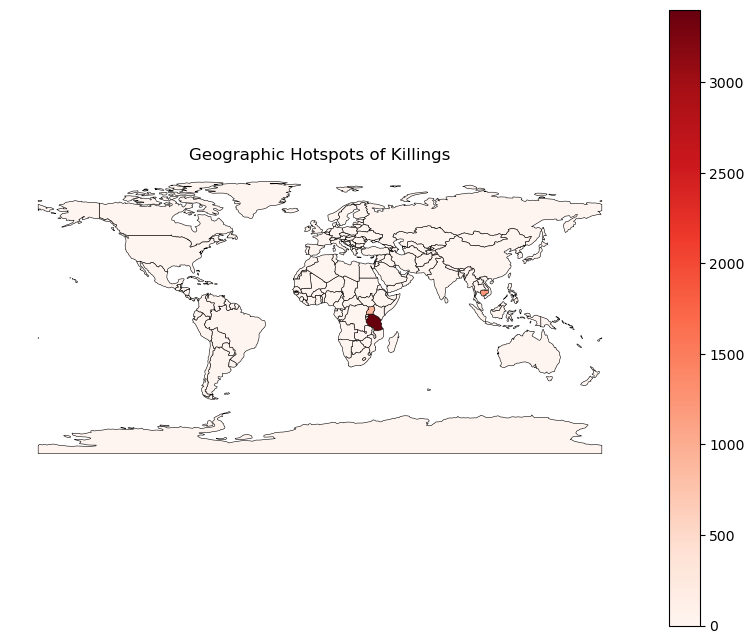

In [38]:
geo = world.merge(killings, on="ISO_A3", how="left")
geo["killings"] = geo["killings"].fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))

geo.plot(column="killings", cmap="Reds", legend=True,linewidth=0.4,edgecolor="black",ax=ax)

ax.set_title("Geographic Hotspots of Killings")
ax.axis("off")
plt.show()

## 6. [C] Population Maps 2

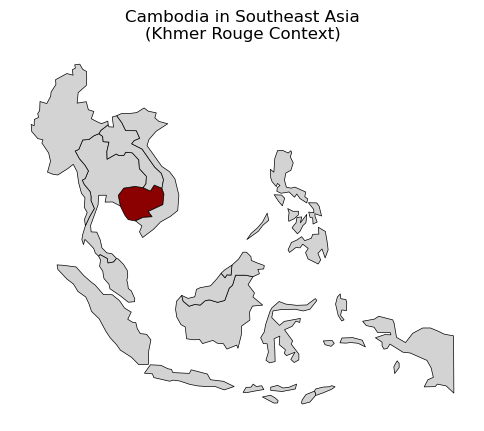

In [39]:
# Southeast Asia ISO abbreviations
sea_iso = ["KHM", "THA", "VNM", "LAO", "MMR","MYS", "SGP", "IDN", "PHL", "BRN", "TLS"]

sea = world[world["ISO_A3"].isin(sea_iso)].copy()

# Cambodias indicator
sea["is_cambodia"] = sea["ISO_A3"] == "KHM"

fig, ax = plt.subplots(figsize=(6, 6))
sea.plot(ax=ax,
        color=sea["is_cambodia"].map({True: "darkred", False: "lightgray"}),
        edgecolor="black",
        linewidth=0.5)

ax.set_title("Cambodia in Southeast Asia\n(Khmer Rouge Context)")
ax.axis("off")
plt.show()

## 7. [C] Other Visualization Tools

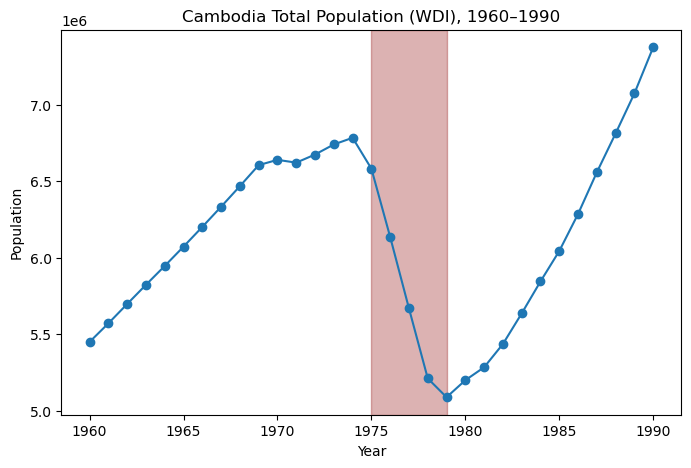

In [40]:
years = list(range(1960, 1991))
vals = []
for y in years:
    try:
        vals.append(population(y, "people", (0,100), "KHM"))
    except:
        vals.append(None)  

plt.figure(figsize=(8,5))
plt.plot(years, vals, marker= "o")
plt.axvspan(1975, 1979, color= "darkred", alpha=0.3, label="Khmer Rouge period")

plt.title("Cambodia Total Population (WDI), 1960–1990")
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()

In [41]:
# importing more data json files
burials = gpd.read_file("Burials.geojson")
prisons = gpd.read_file("Prisons.geojson")
memorials = gpd.read_file("Memorials.geojson")

burials.head()

,OBJECTID,ID_CODE,ID_PROVINC,ID_DISTRIC,TYPE,EXECUTION_,MASSGRAVES,PHOTO,BODIES,geometry
0,1.0,210901,21,2109,Pit,Yes,21,None,10043,POINT (455839.125 1211969.125)
1,2.0,211001,21,2110,Pit,Yes,16,None,0,POINT (472981.25 1193943.625)
2,3.0,211002,21,2110,Other,None,0,None,0,POINT (474773.812 1209777.875)
3,4.0,210601,21,2106,Other,Yes,0,None,0,POINT (493164.813 1232153.25)
4,5.0,210602,21,2106,Other,None,1,None,100,POINT (493168.625 1231169.75)


## 7. [C] Other Visualization Tools 2

In [42]:
cambodia = world[world["ADM0_A3"] == "KHM"]

In [43]:
# used crs to accurately depict coordinate references
burials = burials.to_crs(cambodia.crs)
prisons = prisons.to_crs(cambodia.crs)
memorials = memorials.to_crs(cambodia.crs)

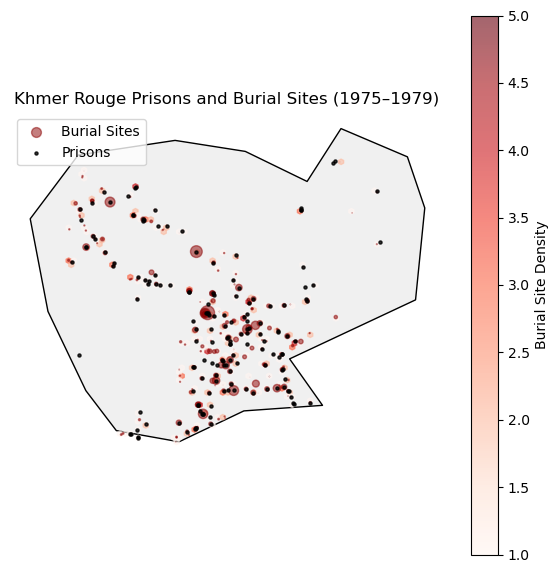

In [44]:
fig, ax = plt.subplots(figsize=(7,7))

# base map
cambodia.plot(ax=ax, color="#f0f0f0", edgecolor="black")

# coordinates
x = burials.geometry.x
y = burials.geometry.y

# density layer
hb = ax.hexbin(x, y,
            gridsize=60,
            cmap="Reds",
            alpha=0.6,
            mincnt=1)

# actual points
burials.plot(ax=ax,
            color="darkred",
            markersize=burials["BODIES"].clip(lower=1) / 700,
            alpha=0.5,
            label="Burial Sites")

prisons.plot(ax=ax,
            color="black",
            markersize=5,
            alpha=0.8,
            label="Prisons")

ax.set_title("Khmer Rouge Prisons and Burial Sites (1975–1979)")
ax.axis("off")
plt.colorbar(hb, ax=ax, label="Burial Site Density")
plt.legend()
plt.show()

## 7. [C] Other Visualization Tools 3

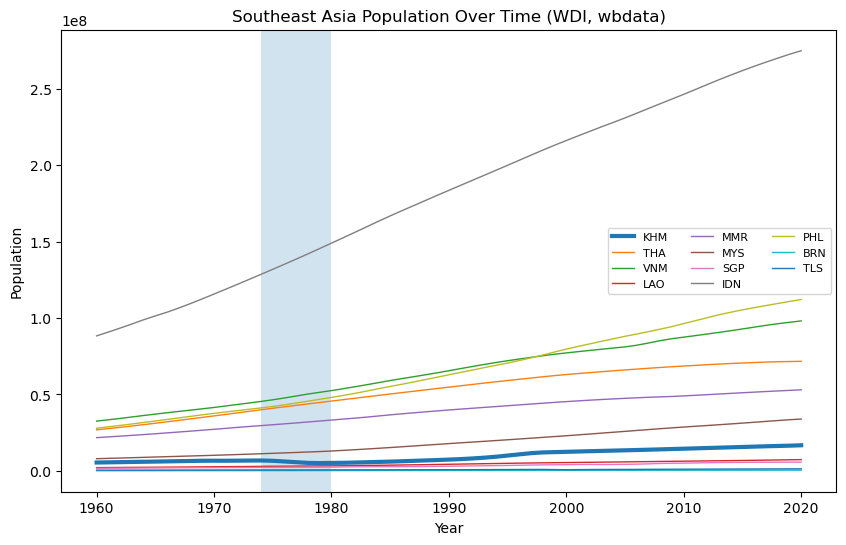

In [45]:
sea_iso = ["KHM", "THA", "VNM", "LAO", "MMR","MYS", "SGP", "IDN", "PHL", "BRN", "TLS"]

# relevant ranges
years = list(range(1960, 2021))

rows = []
for iso in sea_iso:
    for y in years:
        try:
            val = population(y, "people", (0,100), iso)
        except Exception:
            val = None
        rows.append({"iso3": iso, "year": y, "pop": val})

sea_pop = pd.DataFrame(rows)

plt.figure(figsize=(10,6))
for iso in sea_iso:
    sub = sea_pop[sea_pop["iso3"] == iso].sort_values("year")
    if iso == "KHM":
        plt.plot(sub["year"], sub["pop"], label=iso, linewidth=3)
    else:
        plt.plot(sub["year"], sub["pop"], label=iso, linewidth=1)

plt.axvspan(1974, 1980, alpha=0.2)
plt.title("Southeast Asia Population Over Time (WDI, wbdata)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend(ncol=3, fontsize=8)
plt.show()